<a href="https://colab.research.google.com/github/Elfeny7/ComputerVision_Learn/blob/main/Human_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2 as cv
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import numpy as np
import os
import gdown
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [3]:
directory = '/content/drive/My Drive/PCVK'

yolov3w = f'{directory}/yolov3-tiny.weights'
yolov3c = f'{directory}/yolov3-tiny.cfg'
cn = f'{directory}/coco.names'

In [8]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/

In [9]:
!pip install kaggle

In [10]:
!kaggle datasets download -d constantinwerner/human-detection-dataset

 99% 258M/260M [00:02<00:00, 126MB/s]
100% 260M/260M [00:02<00:00, 122MB/s]


In [11]:
with zipfile.ZipFile('human-detection-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [12]:
# Definisikan path dataset
dataset_path = "dataset/human detection dataset"

# Definisikan parameter untuk data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Menentukan persentase data untuk validasi
)

# Load seluruh dataset dengan pembagian data validasi
generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(generator, epochs=10)

# Save
model.save('human_detection_model.h5')

Found 921 images belonging to 2 classes.
Epoch 1/10
29/29 [==============================] - 22s 331ms/step - loss: 0.6712 - accuracy: 0.5961
Epoch 2/10
29/29 [==============================] - 10s 362ms/step - loss: 0.6533 - accuracy: 0.6221
Epoch 3/10
29/29 [==============================] - 9s 295ms/step - loss: 0.6399 - accuracy: 0.6526
Epoch 4/10
29/29 [==============================] - 11s 365ms/step - loss: 0.6316 - accuracy: 0.6667
Epoch 5/10
29/29 [==============================] - 9s 300ms/step - loss: 0.6251 - accuracy: 0.6710
Epoch 6/10
29/29 [==============================] - 9s 317ms/step - loss: 0.6098 - accuracy: 0.6623
Epoch 7/10
29/29 [==============================] - 11s 371ms/step - loss: 0.6175 - accuracy: 0.6645
Epoch 8/10
29/29 [==============================] - 10s 349ms/step - loss: 0.6148 - accuracy: 0.6623
Epoch 9/10
29/29 [==============================] - 10s 339ms/step - loss: 0.6187 - accuracy: 0.6764
Epoch 10/10
29/29 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Ada manusia dalam gambar.


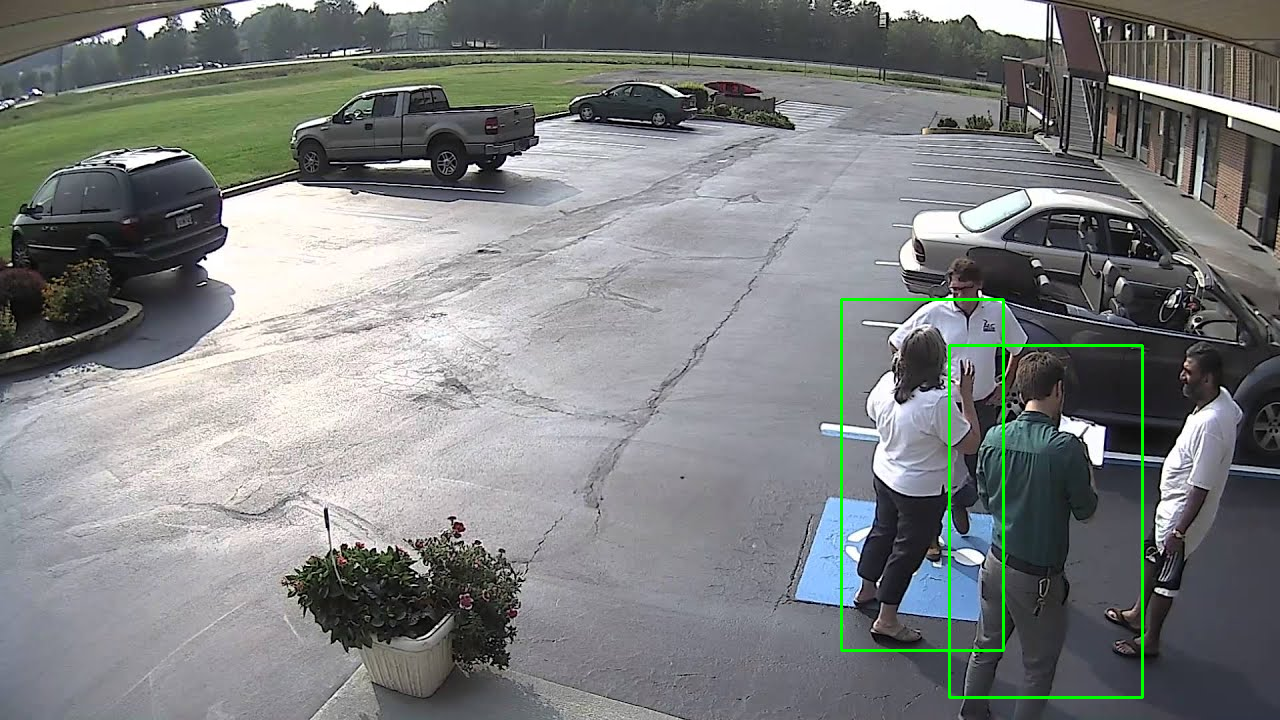

Jumlah manusia: 2


In [15]:

def detect_and_count_humans(image_path):
    # Load model YOLOv3
    net = cv.dnn.readNet(yolov3w, yolov3c)

    # Baca gambar
    image = cv.imread(image_path)
    height, width = image.shape[:2]

    # Konversi gambar ke format blob yang digunakan oleh YOLO
    blob = cv.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

    # Set input ke model YOLO
    net.setInput(blob)

    # Jalankan deteksi objek
    layer_names = net.getUnconnectedOutLayersNames()
    outputs = net.forward(layer_names)

    # Inisialisasi list untuk menyimpan koordinat manusia yang terdeteksi
    human_coordinates = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5 and class_id == 0:  # Class_id 0 adalah manusia
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Hitung koordinat sudut kotak
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                human_coordinates.append((x, y, x + w, y + h))

    # Hitung jumlah manusia dalam gambar
    count = len(human_coordinates)

    if count > 0:
        print("Ada manusia dalam gambar.")
    else:
        print("Tidak ada manusia dalam gambar.")

    # Tampil gambar dengan kotak
    for (x1, y1, x2, y2) in human_coordinates:
        cv.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Tampilkan gambar dengan kotak dan teks
    cv2_imshow(image)
    cv.waitKey(0)
    cv.destroyAllWindows()

    return count

image_path = "cctv2.jpg"
jumlah_manusia = detect_and_count_humans(image_path)
print("Jumlah manusia:", jumlah_manusia)


## **Yolo v8**

In [16]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118


In [17]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [18]:
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5

%cd {HOME}/yolov5
!pip install -r requirements.txt

from IPython import display
display.clear_output()

In [19]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.5/78.2 GB disk)


In [20]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

from IPython import display
display.clear_output()

import detectron2
print("detectron2:", detectron2.__version__)

detectron2: 0.6


In [21]:
!pip install supervision==0.2.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.2.0


## **Process**

In [22]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 157MB/s]


In [23]:
VIDEO_PATH = f"{directory}/video.mp4"


0: 736x1280 44 persons, 1 backpack, 4 handbags, 1 tennis racket, 96.0ms
Speed: 7.7ms preprocess, 96.0ms inference, 54.6ms postprocess per image at shape (1, 3, 736, 1280)


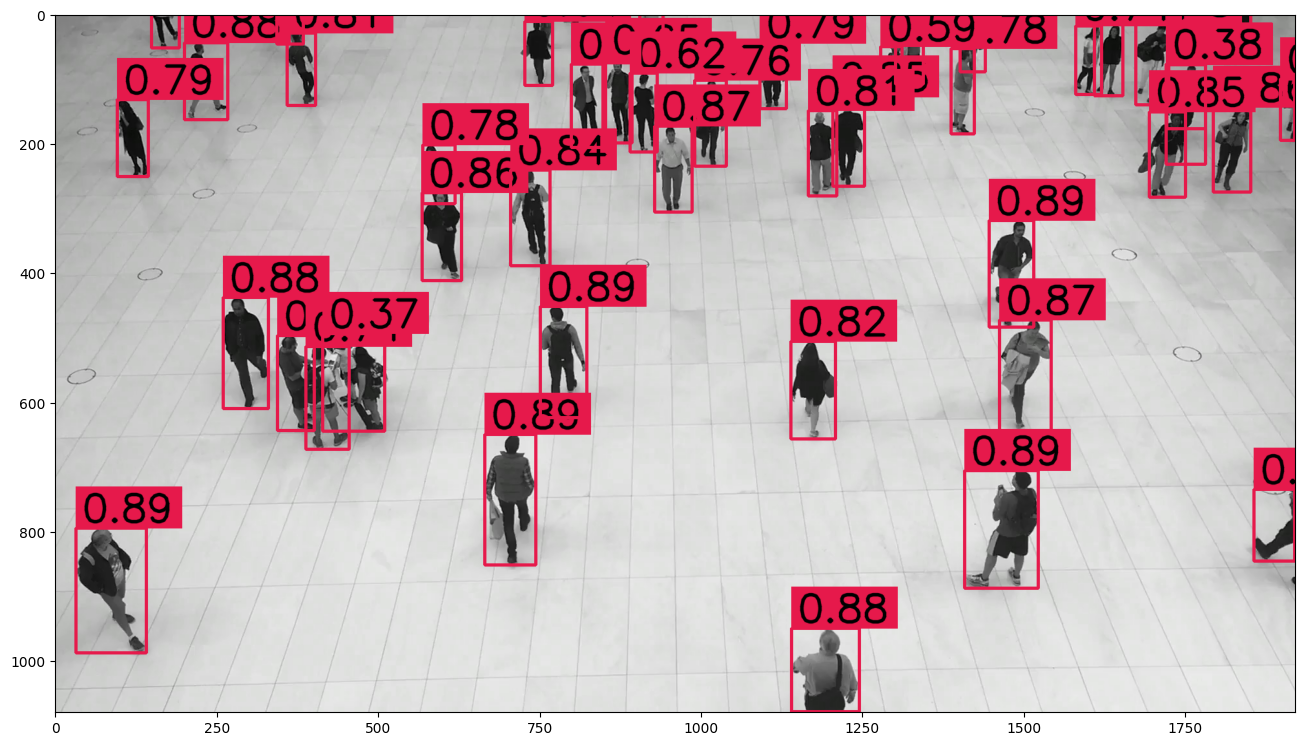

In [24]:
import supervision as sv
import numpy as np

#extrect video from frame
generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

#detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
#detect_only_person
detections = detections[detections.class_id == 0]

#annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16,16))

In [25]:
sv.VideoInfo.from_video_path(VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=25, total_frames=341)


0: 736x1280 44 persons, 1 backpack, 4 handbags, 1 tennis racket, 30.1ms
Speed: 7.5ms preprocess, 30.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


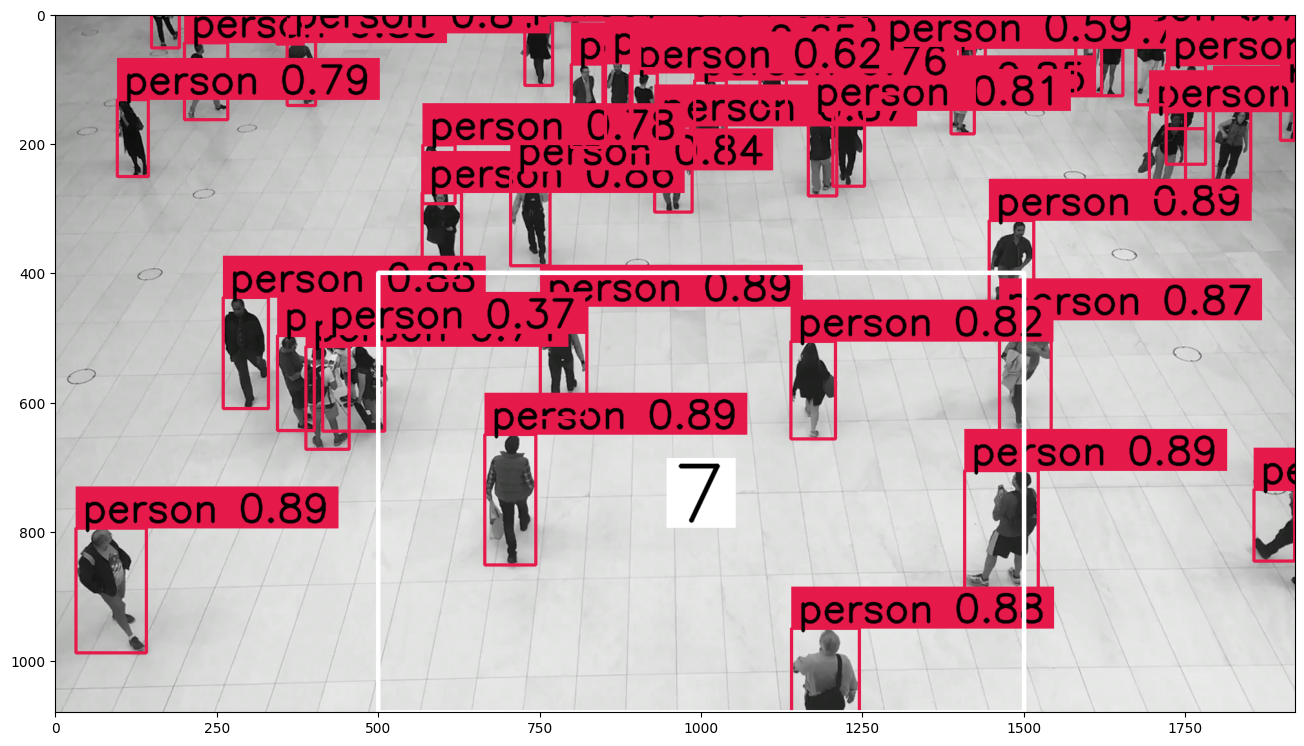

In [26]:
import supervision as sv
import numpy as np

# initiate polygon zone
polygon = np.array([
    [500, 400],
    [1500, 400],
    [1500, 1080],
    [500, 1080]
])
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

#extrect video from frame
generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

#detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
#detect_only_person
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

#annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16,16))

### **Simpan Video**

In [28]:
import supervision as sv
import numpy as np

# initiate polygon zone
polygon = np.array([
    [500, 400],
    [1500, 400],
    [1500, 1080],
    [500, 1080]
])
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

def process_frame(frame: np.ndarray, _) -> np.ndarray:
  #detect
  results = model(frame, imgsz=1280)[0]
  detections = sv.Detections.from_yolov8(results)
  #detect_only_person
  detections = detections[detections.class_id == 0]
  zone.trigger(detections=detections)

  #annotate
  box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
  labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
  frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
  frame = zone_annotator.annotate(scene=frame)

  return frame

sv.process_video(source_path=VIDEO_PATH, target_path=f"{HOME}/video-result.mp4", callback=process_frame)

from IPython import display
display.clear_output()